# Generative modelling in deep learning

By Ziting Qiu, Zhiqing Chen, Kehan Wang

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

>1. Kullback Leibler, KL Divergence
2. Jensen Shannon divergence, JS Divergence. It is a variation of KL divergence
3. Optimal transport divergence, i.e. Earth mover distance
4. Minimum mean discrepancy, MMD

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> When we compare the sampled values, we should consider whether the sampled data are representative, from which distribution we can sample, is the sampling distribution can reflect the real-word data distribution and so on. What's more, the calculation time of sampling method is relatively long, especially when the dataset is large, since each data point should participate in each iteration.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> The input noise dimension has a significant effect on the results. N dimenisons of the input noise will decide N factors of the target.  Generally, the input noise dimension is lower than the target data dimension. And GAN learns a mapping from lower-dimension noise to real-world high dimension data sample. Since in the manifold hypothesis, the real-world high dimensional data lie on low dimensional manifolds embedded in high dimensional space. Hence, we believe that the data can have an efficient lower-dimensional representation. 
However, if the input noise dimension is too low, such as 1-dimension, GAN is hardly able to explore the sample space thus can't learn efficient mappings even though after huge iterations.
Different dimensions can cause differences in coverage, uniformity, and amount of sampling in negative space. We can't tell an optimal dimension for all the cases, since the optimal noise dimension depends on the dataset and which GAN architecture used. 

https://arxiv.org/pdf/2004.06882.pdf
https://towardsdatascience.com/why-do-gans-need-so-much-noise-1eae6c0fb177

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> JS divergence is always log2 if two distributions do not overlap, i.e. same objective value is obtained. In this case, even though the $p_\theta$ and $p_D$ are closer to each other, the JSD will give the equally bad evaluation log2.
What's more, in most cases, $p_\theta$ and $p_D$  are not overlap. There are two reasons to justify: ①The nature of the data, since both $p_\theta$ and $p_D$ are low-dimension manifold in high-dimension space, the overlap of them can be ignored. ② Sampling: Even though $p_\theta$ and $p_D$ have overlap, after the random sampling, the overlap can be ignored as well. 


Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> The generator won't know if its generated data can cover all the modes of the real data. When the discriminator is very successful, the mode collapse and gradient vanishing may happen.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [2]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

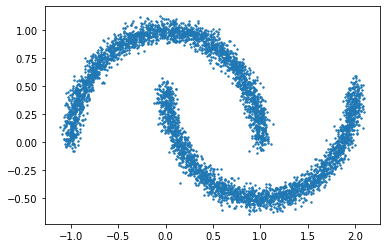

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(PRIOR_N, 128),
            nn.ReLU(True),
            nn.Linear(128,2)
        )
        
    def __call__(self, z):
        return self.gen(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)   # z_size=[batchlen,prior_N]
        return self.__call__(z)                               # output_size = [batchlen,2] , 2 is the target dimension
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(2,128),
            nn.ReLU(True),
            nn.Linear(128,128),
            nn.ReLU(True),
            nn.Linear(128,128),
            nn.ReLU(True),
            nn.Linear(128,1)
        )
    
    def __call__(self, x):
        return self.disc(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.392e+00, generator: 6.795e-01


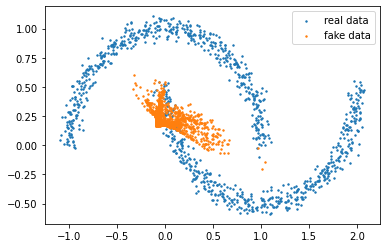

step 1000: discriminator: 1.261e+00, generator: 7.528e-01


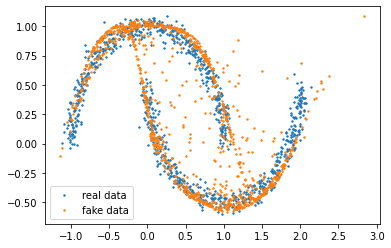

step 2000: discriminator: 1.351e+00, generator: 8.780e-01


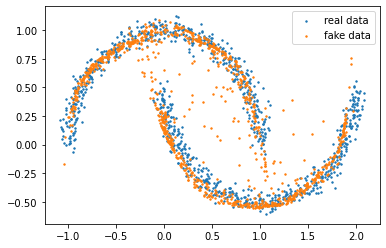

step 3000: discriminator: 1.360e+00, generator: 8.133e-01


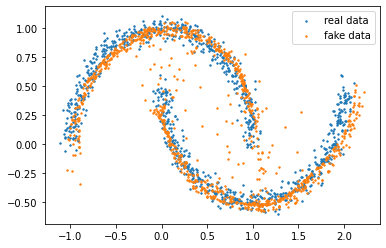

step 4000: discriminator: 1.350e+00, generator: 8.302e-01


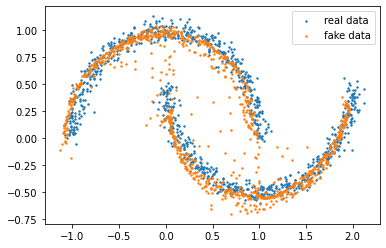

step 5000: discriminator: 1.371e+00, generator: 7.269e-01


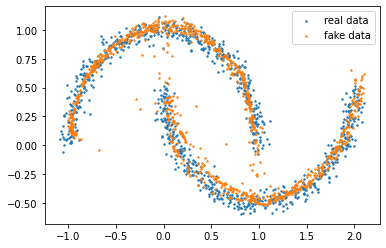

step 6000: discriminator: 1.370e+00, generator: 8.516e-01


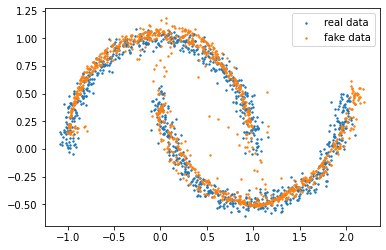

step 7000: discriminator: 1.382e+00, generator: 8.385e-01


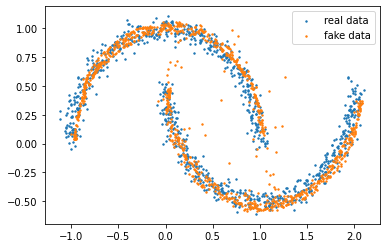

step 8000: discriminator: 1.384e+00, generator: 7.754e-01


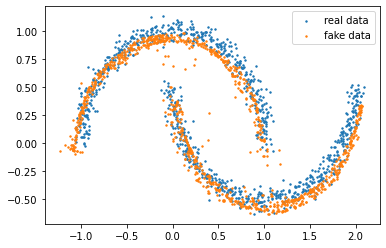

step 9000: discriminator: 1.384e+00, generator: 7.203e-01


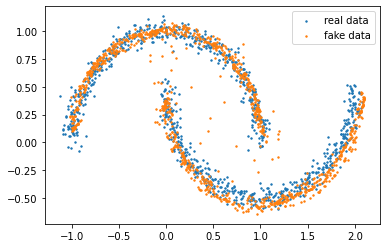

step 10000: discriminator: 1.391e+00, generator: 8.463e-01


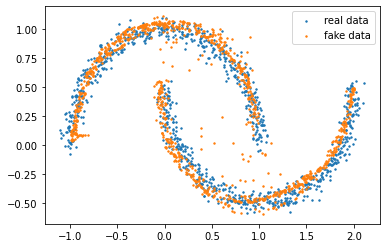

step 11000: discriminator: 1.367e+00, generator: 7.608e-01


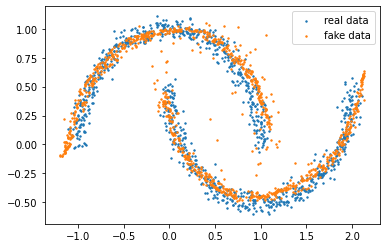

step 12000: discriminator: 1.351e+00, generator: 7.972e-01


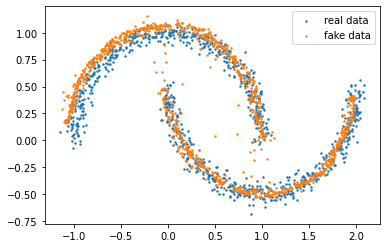

step 13000: discriminator: 1.367e+00, generator: 7.772e-01


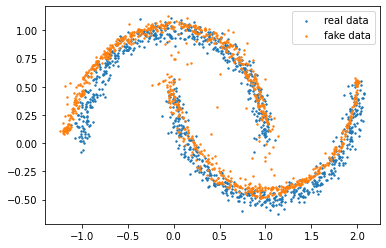

step 14000: discriminator: 1.367e+00, generator: 7.985e-01


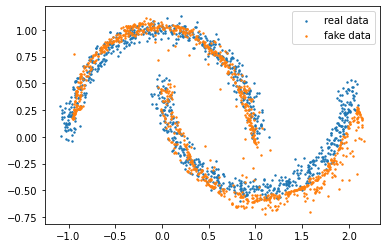

step 15000: discriminator: 1.380e+00, generator: 7.649e-01


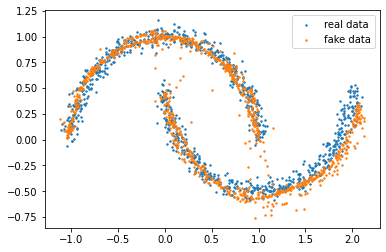

step 16000: discriminator: 1.385e+00, generator: 7.148e-01


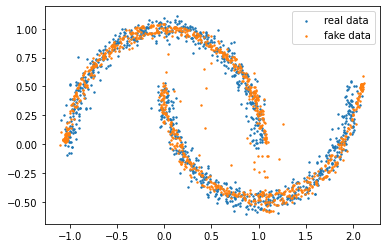

step 17000: discriminator: 1.395e+00, generator: 7.157e-01


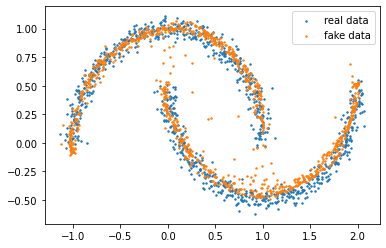

step 18000: discriminator: 1.371e+00, generator: 7.552e-01


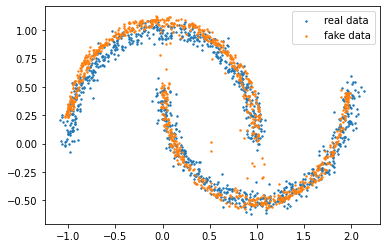

step 19000: discriminator: 1.374e+00, generator: 7.894e-01


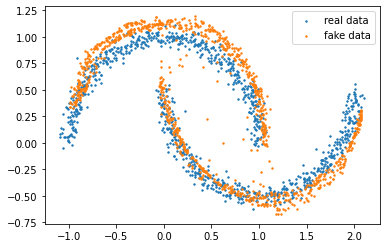

step 20000: discriminator: 1.380e+00, generator: 7.409e-01


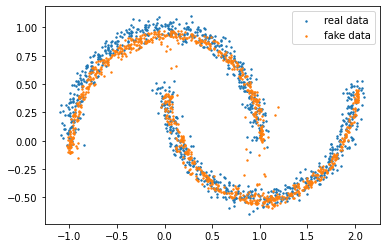

In [31]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128
criterion = nn.BCEWithLogitsLoss()
generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        real_out = discriminator(real_batch)    #put the real data to discriminator, size = [BATCHLEN,1 ]
        fake_out = discriminator(fake_batch)    #put the generated data to discriminator, size = [BATCHLEN,1 ]
        d_real_error = criterion(real_out, Variable(torch.ones(BATCHLEN,1)))
        d_fake_error = criterion(fake_out, Variable(torch.zeros(BATCHLEN,1)))
        disc_loss = d_real_error+d_fake_error
        #
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    output = discriminator(fake_batch)            #put the generated data to discriminator, size = [BATCHLEN,1 ]
    gen_loss = criterion(output,  Variable(torch.ones(BATCHLEN,1)))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> When we use $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$  as the generator's loss, and when we train an optimal discriminator in the last step, i.e.$D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, then the generator's loss is equivalent to $$ \mathcal{L}_G = -2 \left( \log 2 - JSD(p_D \| p_\theta) \right) $$ 
However, there is problem with the JS divergence. When there is no overlap between two distribution, the JS divergence will always be $\log 2$. So $ \mathcal{L}_G$  will be a constant. When we calculate the gradient, it will be 0, that is the gradient vanishing. The generator has no information for improving, it will completely collapse quickly.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> - Impact of depth / width of the generator: when the generator network is shallow and thin, the generated data seems to be similar and wrong at the later interations, i.e. the generator mostly stops learning. What's more, even though I tried deep and wide generator, convergence can't be achieved until we increase the depth/width of discriminator network. That is because little information from discriminator make the generator unble to generate well. 

> - Impact of depth / width of the discriminator network, when the discriminator network is shallow and thin, we can't get good results. When we increase the width of the discriminator, the generated data can be improved but they don't converge yet. When we increase both the depth and width, we can see convergence and good generated data quickly. However, when we continue to increase the complexity of the discriminator, the problem of gradient vanishing will happen. So we should choose a moderate network for discriminator.

> From the tunning of generator and discriminator network, we can see that the network of discriminator, especially the depth of discriminator can significantly control the quality of the generated data. The complex generator network are not able to succeed without the feedback from a good discriminator. Also, we should notice that the discriminator can't be too good, which will cause gradient vanishing.

> - Impact of Train_ratio: Generally, we will update discriminator several times before updating generators. However, larger train_ratio can make the training process less stable in the later interations. We can observe amount of sampling in negative space. The reason might be that a too good discriminator accordingly cause the unstable of the generator. Also, larger train_ratio will cause significant longer running time. 

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> $D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right] = \mathbb{E}_{p_D}\left[ log({p_D}) \right] -  \mathbb{E}_{p_D}\left[ log({p_\theta}) \right]$, while $\mathbb{E}_{p_D}\left[ log({p_D}) \right]$ is always constant, Min $D_{KL}(p_D \| p_\theta)$ equals to Min $-  \mathbb{E}_{p_D}\left[ log({p_\theta}) \right]$=>Max $\mathbb{E}_{p_D}\left[ log({p_\theta}) \right]$.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> In fact, p(z)can be any distribution in the process(but generally, poeple use standard normal distribution), because we use p(z) in the first part of our model[encoder]to **study** $q_\phi(z | x)$——a distribution can change to any distribution by transformation function,of which here the parameters are learned by the encoder. So in fact, what we use mainly in VAE is $q_\phi(z | x)$, and we do reparametrization by using $q_\phi(z | x)$ instead of p(z)!

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> $D_{KL}(q_\phi(z | x) \| p(z))
\\=0.5*[tr(\sigma_\phi^2(x))+\mu_\phi(x)^T\mu_\phi(x)-k-log_e(det(\sigma_\phi^2(x)))]
\\=0.5*[tr(\sigma_\phi^2(x))+\mu_\phi(x)^T\mu_\phi(x)-1-log_e(det(\sigma_\phi^2(x)))]$
in which k=1 since we have 2 features in our input.

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> $-\log p_\theta(x | z)
\\=0.5*[(x_\theta-\mu_\theta(z))^T*Diag(\sigma_\theta^2(z))^{-1}*(x_\theta-\mu_\theta(z))]+log_e(2\pi^{n/2}*Diag(\sigma_\theta^2(z))^{1/2})
\\=0.5*[(x_\theta-\mu_\theta(z))^T*Diag(\sigma_\theta^2(z))^{-1}*(x_\theta-\mu_\theta(z))]+log_e(2\pi*Diag(\sigma_\theta^2(z))^{1/2})$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as **$(\mu, \log\sigma^2)$**, rather than $(\mu, \sigma)$.

In [6]:
import torch.nn.functional as F
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, 6)
        self.fc_mu_1 = nn.Linear(6,LATENT_N)
        self.fc_logvar = nn.Linear(2, 6)
        self.fc_logvar_1 = nn.Linear(6,LATENT_N)
        self.training = True
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        mu = F.relu(mu)
        mu = self.fc_mu_1(mu)
        logvar = self.fc_logvar(x)
        logvar = F.relu(logvar)
        logvar = self.fc_logvar_1(logvar)
        return (mu, logvar) #返回 后验 z|x 的mean和logvariance[去平滑variance，otherwise训练出来的z不平稳]的vector 和matrix
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        #self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_mu = nn.Linear(LATENT_N, 6)
        self.fc_mu_1 = nn.Linear(6,6)
        self.fc_mu_2 = nn.Linear(6,2)
        self.fc_logvar = nn.Linear(LATENT_N, 6)
        self.fc_logvar_1 = nn.Linear(6,6)
        self.fc_logvar_2 = nn.Linear(6,2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = F.relu(self.fc_mu(z))
        mu = F.relu(self.fc_mu_1(mu))
        mu = self.fc_mu_2(mu)
        logvar = F.relu(self.fc_logvar(z))
        logvar = F.relu(self.fc_logvar_1(logvar))
        logvar = self.fc_logvar_2(logvar)
        return (mu, logvar)

    def generate(self, batchlen): 
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)#此处的z指的是噪声的分布
        (mu, logvar) = self.__call__(z) #这个指的是 x|z 的mean和 logvar
        return torch.normal(mu, torch.exp(0.5*logvar)) #生成的x

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.167e+02, rec: 6.131e+02


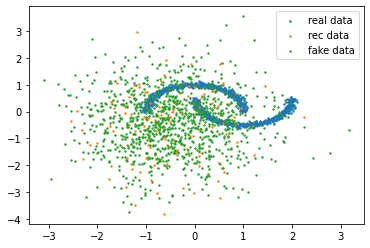

step 1000: KL: 1.604e-03, rec: 6.223e+02


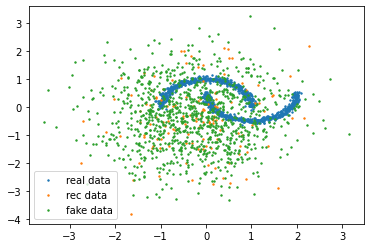

step 2000: KL: 5.870e-04, rec: 6.579e+02


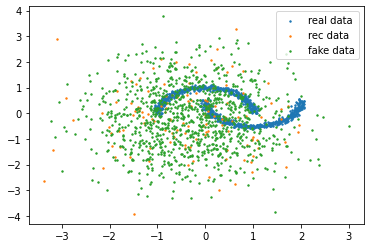

step 3000: KL: 6.999e-04, rec: 6.295e+02


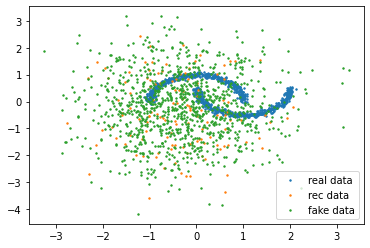

step 4000: KL: 9.607e-04, rec: 6.306e+02


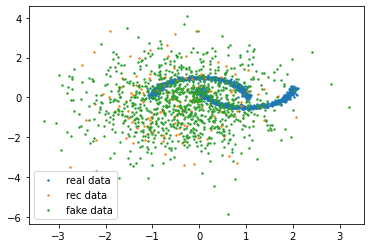

step 5000: KL: 1.056e-03, rec: 6.470e+02


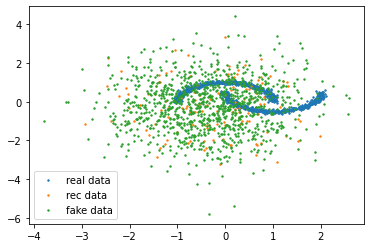

step 6000: KL: 7.733e-04, rec: 6.727e+02


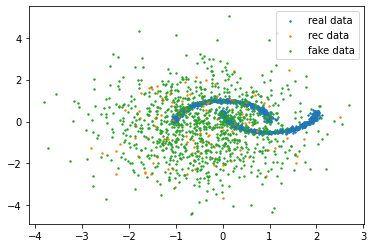

step 7000: KL: 9.958e-04, rec: 6.514e+02


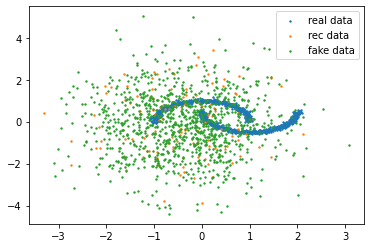

step 8000: KL: 3.002e-03, rec: 6.445e+02


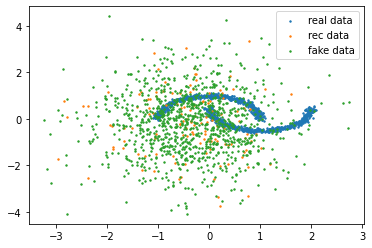

step 9000: KL: 3.828e-04, rec: 6.222e+02


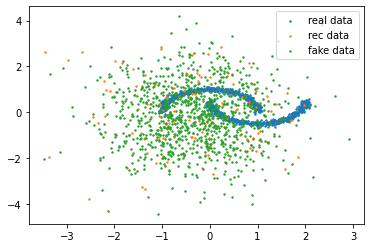

step 10000: KL: 1.420e-03, rec: 6.321e+02


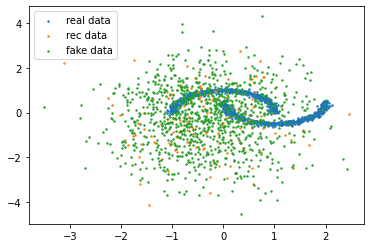

step 11000: KL: 1.730e-03, rec: 6.534e+02


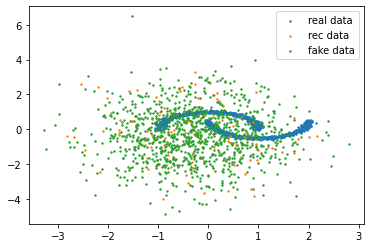

step 12000: KL: 1.237e-03, rec: 6.135e+02


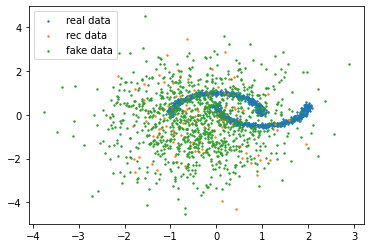

step 13000: KL: 7.390e-04, rec: 6.358e+02


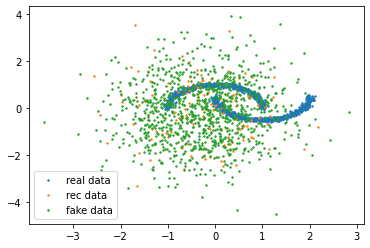

step 14000: KL: 5.252e-04, rec: 6.179e+02


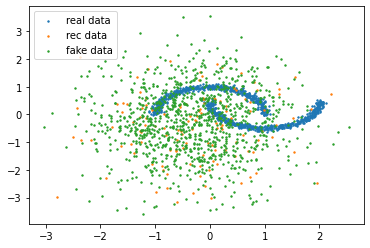

step 15000: KL: 6.371e-04, rec: 6.122e+02


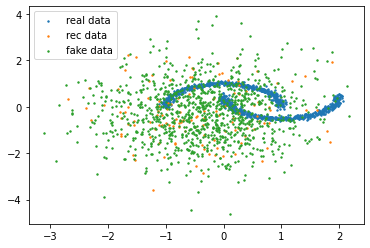

step 16000: KL: 3.929e-04, rec: 6.240e+02


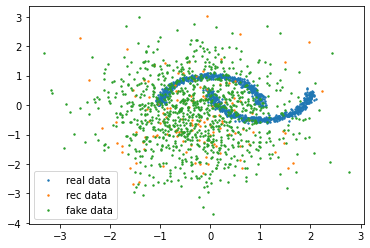

step 17000: KL: 1.034e-03, rec: 5.917e+02


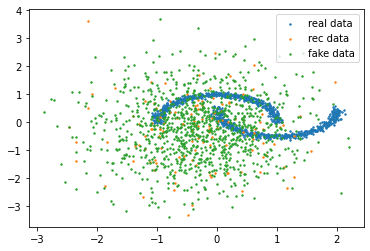

step 18000: KL: 3.311e-04, rec: 5.881e+02


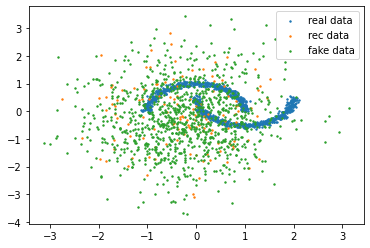

step 19000: KL: 4.366e-04, rec: 5.901e+02


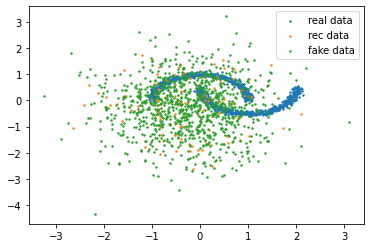

step 20000: KL: 4.957e-04, rec: 5.858e+02


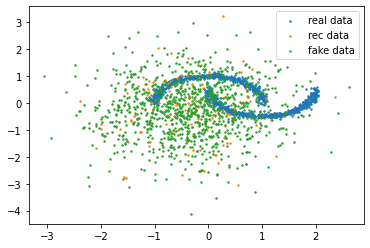

step 21000: KL: 2.055e-04, rec: 5.942e+02


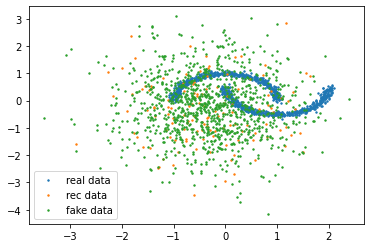

step 22000: KL: 6.351e-04, rec: 5.795e+02


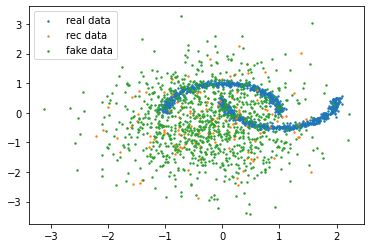

step 23000: KL: 2.868e-04, rec: 5.924e+02


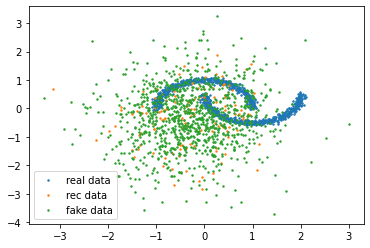

step 24000: KL: 7.664e-04, rec: 5.672e+02


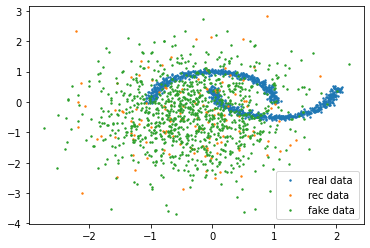

step 25000: KL: 3.035e-04, rec: 6.050e+02


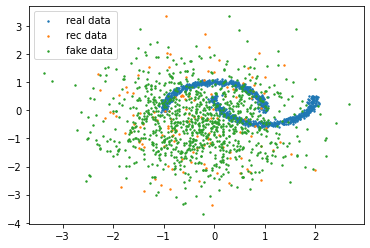

step 26000: KL: 4.239e-04, rec: 6.047e+02


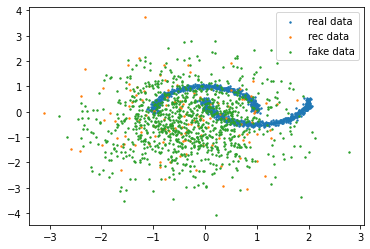

step 27000: KL: 3.187e-04, rec: 6.018e+02


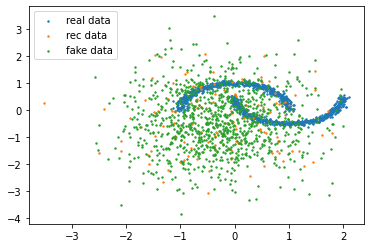

step 28000: KL: 5.370e-04, rec: 5.828e+02


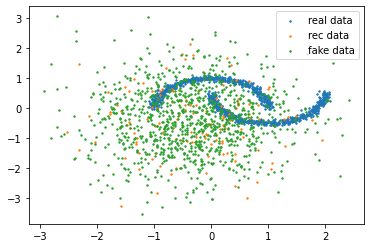

step 29000: KL: 1.661e-04, rec: 5.789e+02


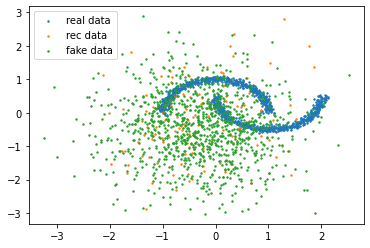

step 30000: KL: 5.015e-04, rec: 6.011e+02


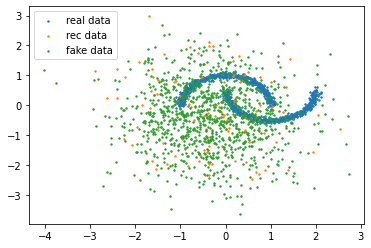

step 31000: KL: 4.510e-04, rec: 5.981e+02


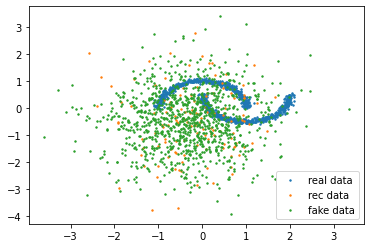

step 32000: KL: 8.127e-04, rec: 5.960e+02


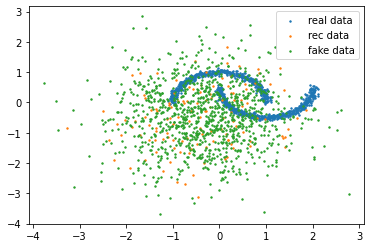

step 33000: KL: 1.333e-04, rec: 5.649e+02


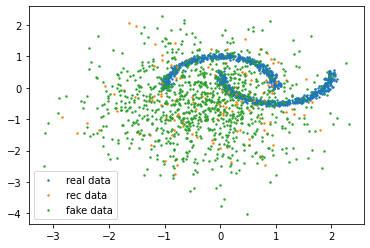

step 34000: KL: 2.114e-04, rec: 5.982e+02


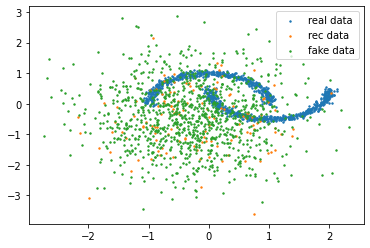

step 35000: KL: 5.425e-04, rec: 5.809e+02


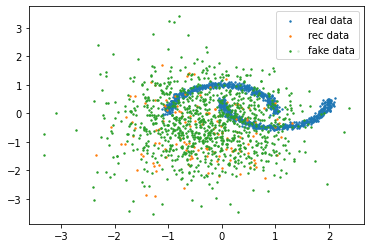

step 36000: KL: 9.653e-05, rec: 5.776e+02


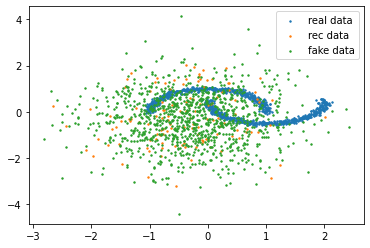

step 37000: KL: 1.014e-04, rec: 5.911e+02


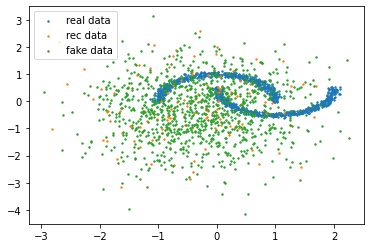

step 38000: KL: 2.105e-03, rec: 5.843e+02


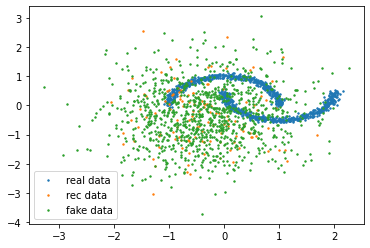

step 39000: KL: 9.535e-04, rec: 5.784e+02


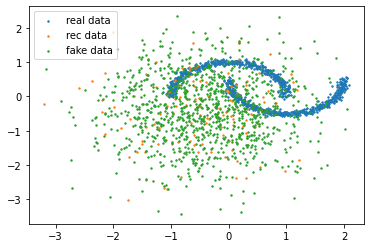

step 40000: KL: 6.659e-04, rec: 5.817e+02


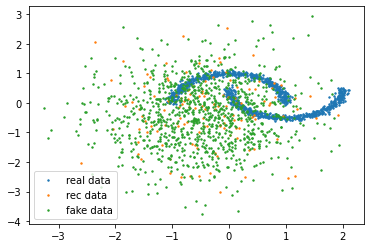

In [8]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #print('enc_logvar',enc_logvar)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    loss_kl =  -0.5 * torch.sum(1 + enc_logvar - enc_mu.pow(2) - enc_logvar.exp())

    # SAMPLE z FROM q(z|x) HERE Monte Carlo 重采样
    std = torch.exp(0.5*enc_logvar) 
    eps = torch.randn_like(std) 
    z = eps*std + enc_mu

    dec_mu, dec_logvar = decoder(z) 

  
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    generate_x_in_batch = decoder.generate(BATCHLEN)

    parta = 0.5*torch.sum((generate_x_in_batch-dec_mu)*(dec_logvar.exp().pow(-1))*(generate_x_in_batch-dec_mu),dim=1)
    partb = torch.sum(np.log(2*np.pi)+0.5*dec_logvar,dim=1)
    loss_rec = torch.sum(parta+partb)
   
  
    (loss_kl+loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**



> When we hardcode $\sigma_\theta(z)$ to some small value (like 1E-4),that means $x_{estimated}$ generated by the decoder approximately equal to the mean generated by decoder(variance/logvariance is almost zero).In this situation, fake data(green dot) are more approached to rec data(orange dot).





> In this question, we hardcode the logvar when we build the architecture of Decoder.Below is the corresponding code.



In [24]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoderv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoderv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
       # self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z, batchlen):
        mu = self.fc_mu(z)
        logvar = torch.tensor([[1e-4,1e-4]*batchlen]).view(batchlen,2) #here we hardcode directly the logvar to [1e-4, 1e-4]
        #logvar = self.fc_logvar(z)
        return (mu,logvar)

    def generate(self, batchlen): 
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        mu,logvar = self.__call__(z, batchlen) 
        return torch.normal(mu,torch.exp(0.5*logvar)) 

step 0: KL: 5.054e+04, rec: 4.755e+00


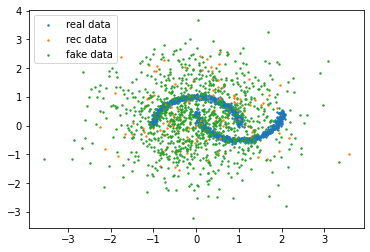

step 1000: KL: 1.607e-02, rec: 4.497e+00


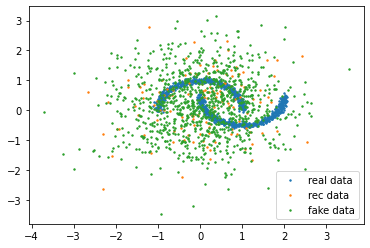

step 2000: KL: 5.810e-03, rec: 4.592e+00


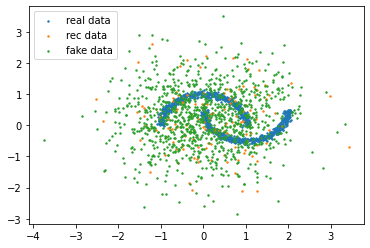

step 3000: KL: 1.659e-02, rec: 4.893e+00


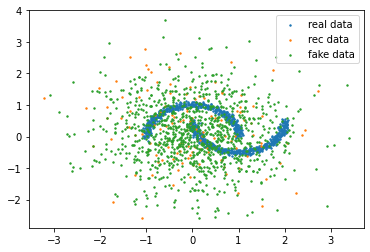

step 4000: KL: 1.513e-02, rec: 4.618e+00


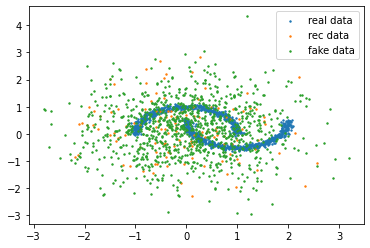

step 5000: KL: 2.039e-02, rec: 4.571e+00


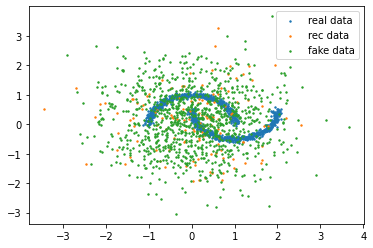

step 6000: KL: 1.589e-02, rec: 4.713e+00


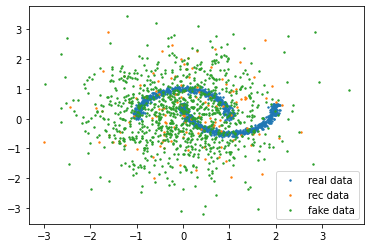

step 7000: KL: 1.582e-02, rec: 4.735e+00


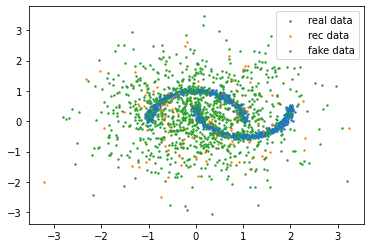

step 8000: KL: 1.131e-02, rec: 4.647e+00


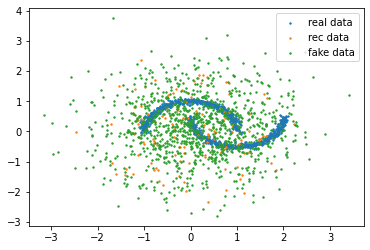

step 9000: KL: 1.706e-02, rec: 4.699e+00


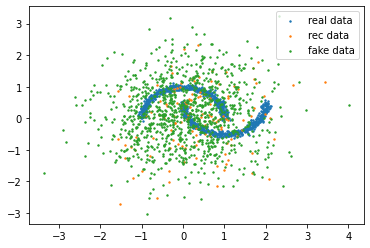

step 10000: KL: 1.493e-02, rec: 4.740e+00


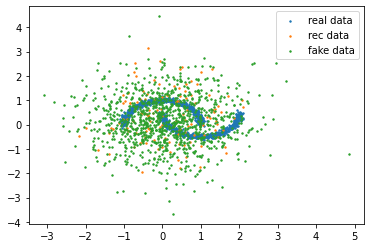

step 11000: KL: 1.309e-02, rec: 4.735e+00


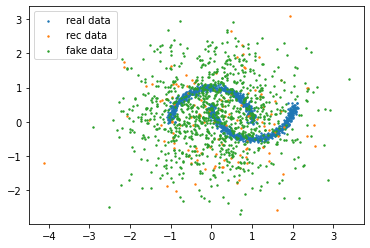

step 12000: KL: 2.063e-02, rec: 4.510e+00


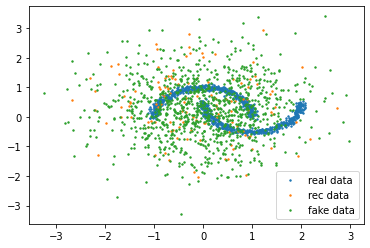

step 13000: KL: 2.392e-02, rec: 4.562e+00


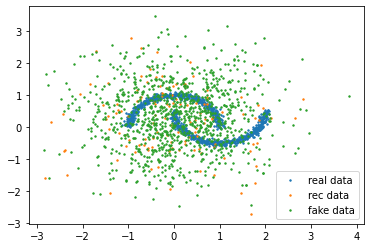

step 14000: KL: 1.440e-02, rec: 4.734e+00


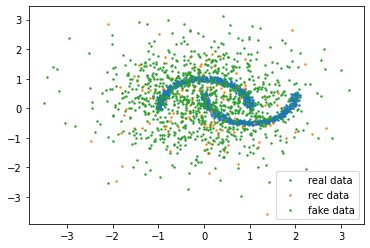

step 15000: KL: 2.046e-02, rec: 4.825e+00


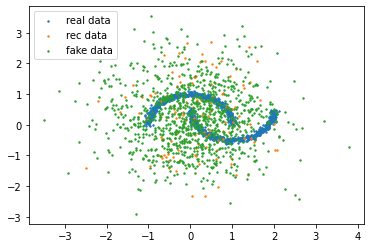

step 16000: KL: 8.018e-03, rec: 4.773e+00


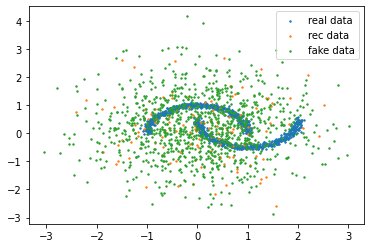

step 17000: KL: 3.712e-03, rec: 4.699e+00


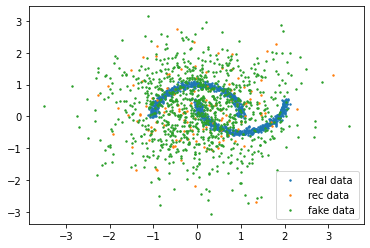

step 18000: KL: 2.495e-02, rec: 4.828e+00


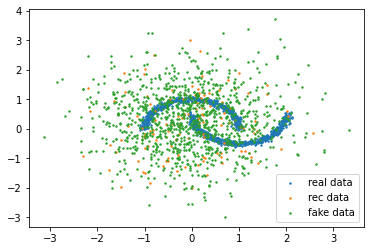

step 19000: KL: 1.825e-02, rec: 4.665e+00


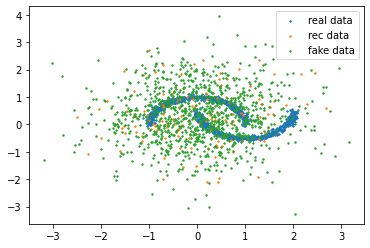

step 20000: KL: 1.082e-02, rec: 4.549e+00


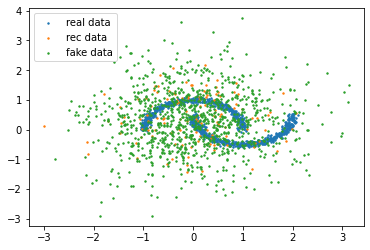

step 21000: KL: 1.897e-02, rec: 4.727e+00


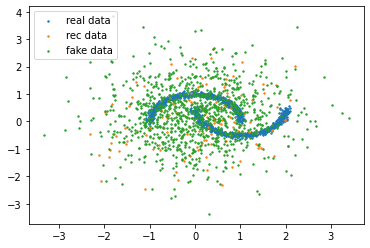

step 22000: KL: 1.201e-02, rec: 4.679e+00


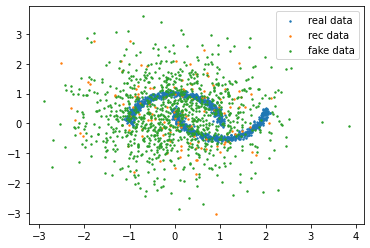

step 23000: KL: 1.244e-02, rec: 4.640e+00


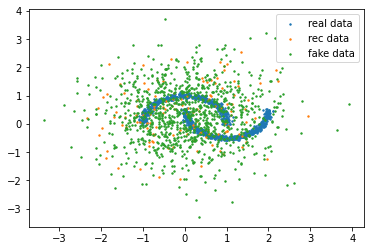

step 24000: KL: 7.118e-03, rec: 4.876e+00


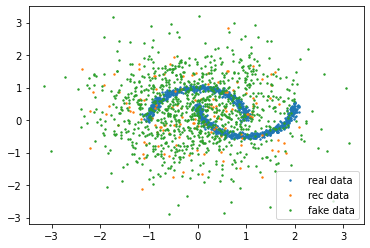

step 25000: KL: 1.025e-02, rec: 4.648e+00


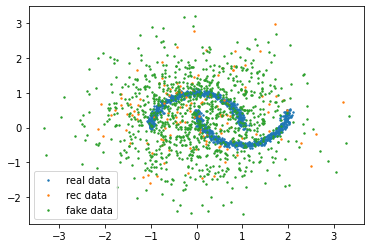

step 26000: KL: 7.439e-03, rec: 4.636e+00


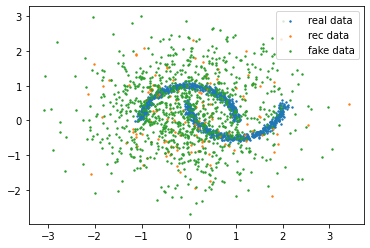

step 27000: KL: 7.381e-03, rec: 4.666e+00


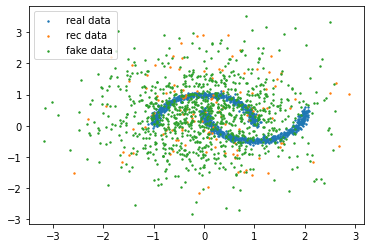

step 28000: KL: 1.740e-02, rec: 4.524e+00


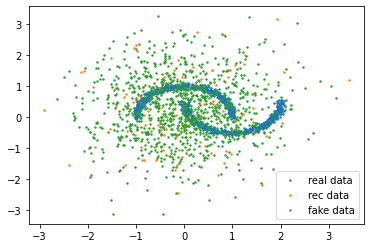

step 29000: KL: 2.402e-02, rec: 4.886e+00


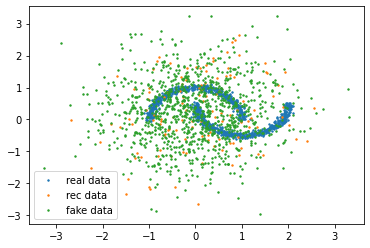

step 30000: KL: 1.891e-02, rec: 4.618e+00


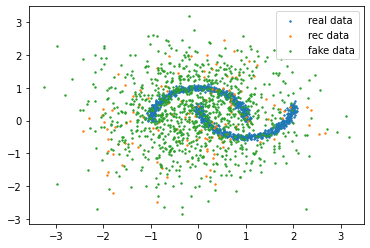

step 31000: KL: 3.521e-03, rec: 4.697e+00


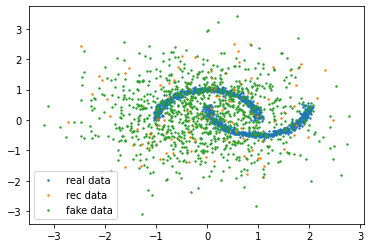

step 32000: KL: 5.722e-03, rec: 4.564e+00


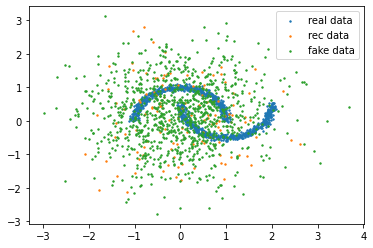

step 33000: KL: 1.386e-02, rec: 4.768e+00


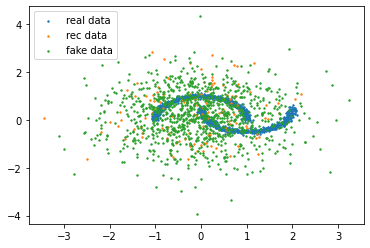

step 34000: KL: 1.680e-02, rec: 4.789e+00


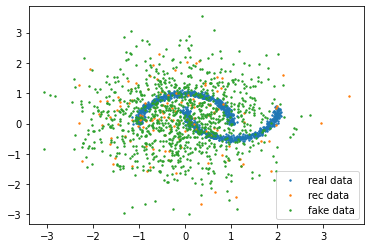

step 35000: KL: 2.629e-02, rec: 4.571e+00


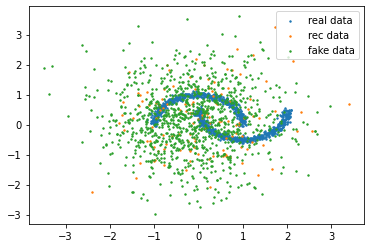

step 36000: KL: 1.755e-02, rec: 4.702e+00


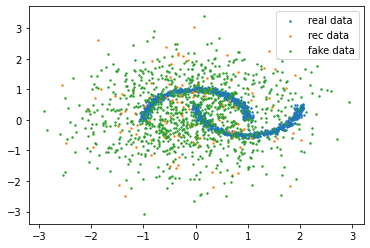

step 37000: KL: 1.285e-02, rec: 4.738e+00


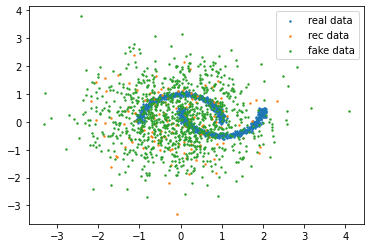

step 38000: KL: 1.262e-02, rec: 4.458e+00


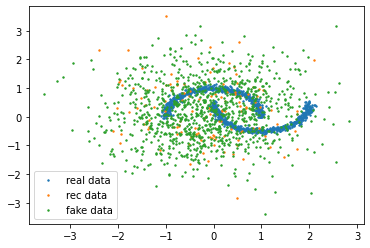

step 39000: KL: 7.954e-03, rec: 4.640e+00


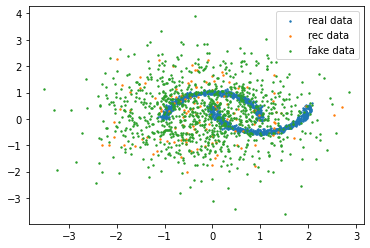

step 40000: KL: 1.476e-02, rec: 4.618e+00


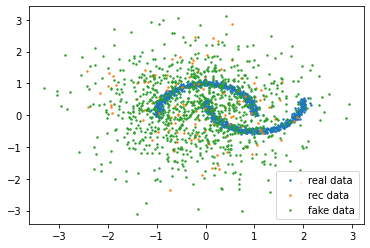

step 41000: KL: 7.210e-03, rec: 4.622e+00


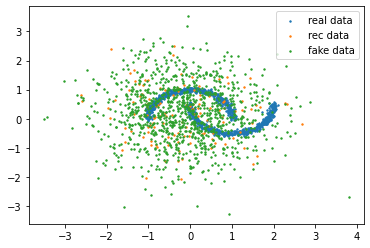

step 42000: KL: 1.663e-02, rec: 4.698e+00


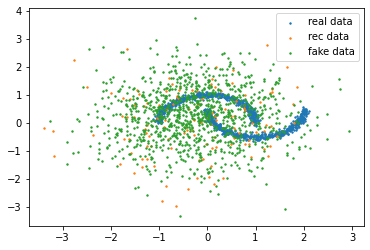

step 43000: KL: 8.549e-03, rec: 4.662e+00


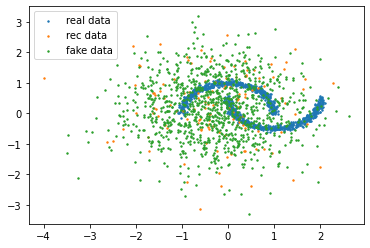

step 44000: KL: 1.453e-02, rec: 4.688e+00


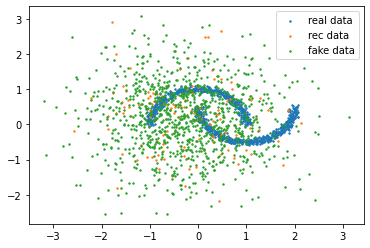

step 45000: KL: 2.233e-02, rec: 4.807e+00


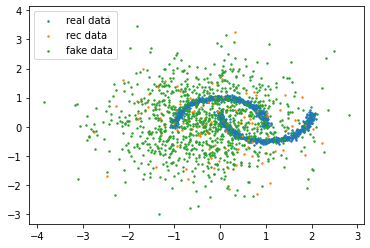

step 46000: KL: 4.440e-03, rec: 4.567e+00


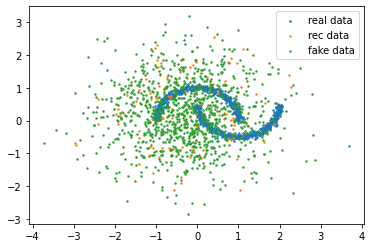

step 47000: KL: 1.272e-02, rec: 4.540e+00


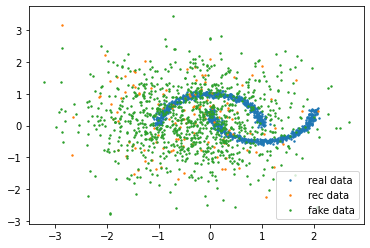

step 48000: KL: 1.955e-02, rec: 4.809e+00


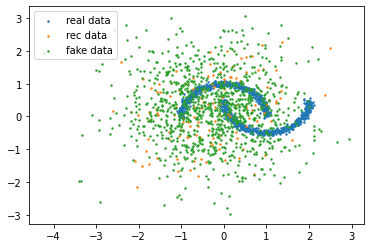

step 49000: KL: 1.115e-02, rec: 4.642e+00


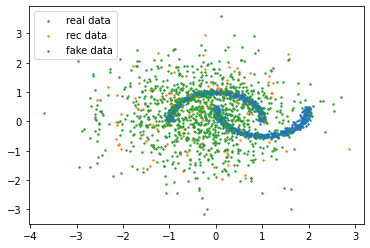

step 50000: KL: 1.286e-02, rec: 4.762e+00


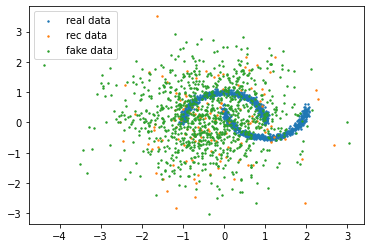

step 51000: KL: 1.100e-02, rec: 4.661e+00


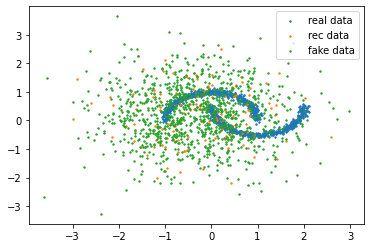

step 52000: KL: 1.300e-02, rec: 4.631e+00


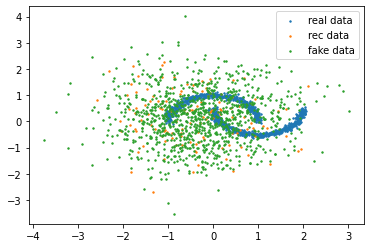

step 53000: KL: 6.985e-03, rec: 4.674e+00


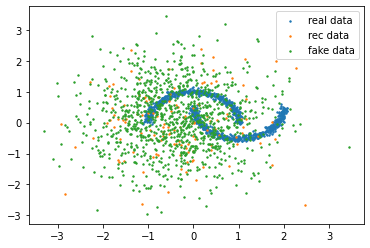

step 54000: KL: 2.669e-02, rec: 4.768e+00


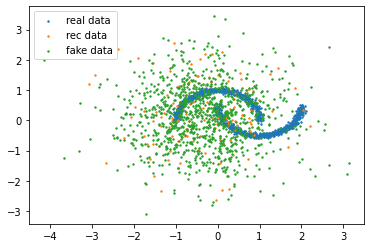

step 55000: KL: 6.542e-03, rec: 4.718e+00


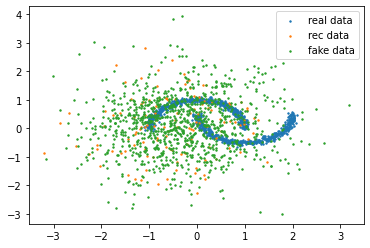

step 56000: KL: 1.662e-02, rec: 4.620e+00


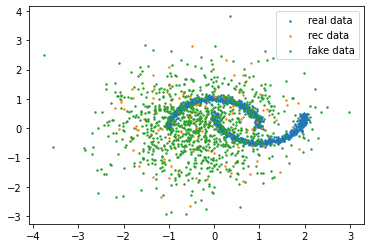

step 57000: KL: 1.406e-02, rec: 4.625e+00


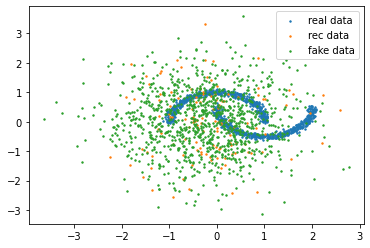

step 58000: KL: 1.277e-02, rec: 4.572e+00


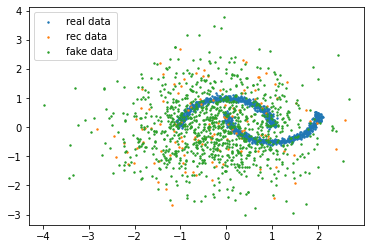

step 59000: KL: 1.184e-02, rec: 4.557e+00


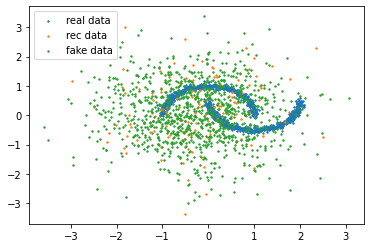

step 60000: KL: 9.861e-03, rec: 4.617e+00


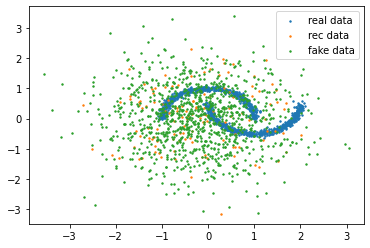

step 61000: KL: 1.814e-02, rec: 4.648e+00


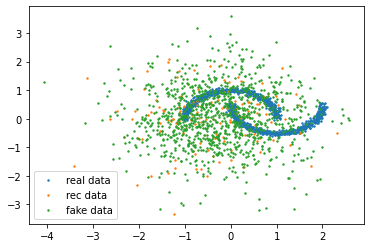

step 62000: KL: 1.307e-02, rec: 4.683e+00


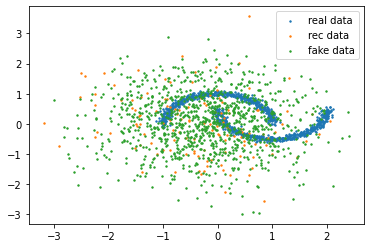

step 63000: KL: 1.914e-02, rec: 4.722e+00


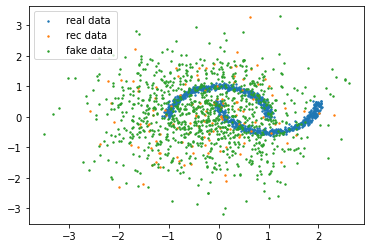

step 64000: KL: 2.217e-02, rec: 4.724e+00


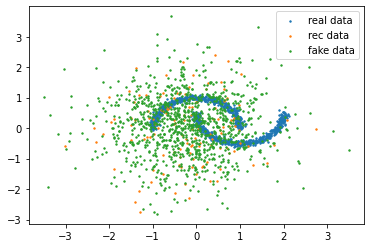

step 65000: KL: 1.779e-02, rec: 4.616e+00


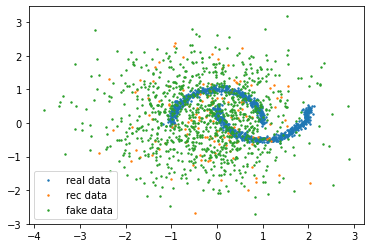

step 66000: KL: 6.596e-03, rec: 4.581e+00


KeyboardInterrupt: ignored

In [31]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoderv2()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoderv2()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    enc_mu, enc_logvar = encoder(x)

    # COMPUTE THE KL PART OF THE LOSS HERE
    loss_kl =  0.5 * torch.sum(-1 - enc_logvar + enc_mu.pow(2) + enc_logvar.exp())

    # SAMPLE z FROM q(z|x) HERE 
    std = torch.exp(0.5*enc_logvar) 
    eps = torch.randn_like(std)
    z = eps.mul(std).add(enc_mu) 
    
    dec_mu, dec_logvar= decoder(z,BATCHLEN) 
  
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    generate_x_in_batch = decoder.generate(BATCHLEN)
    parta = 0.5*torch.sum((generate_x_in_batch-dec_mu)*dec_logvar.exp().pow(-1)*(generate_x_in_batch-dec_mu),dim=1)
    partb = torch.sum(np.log(2*np.pi)+0.5*dec_logvar,dim=1)
    loss_rec = torch.sum(parta+partb)
    
    (loss_kl+loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**



>1. In terms of dimension of hidden state:
In our case,dimension of hidden state doesn't affect the training time and 
performance too much, since the problem is relatively easy to study---we only have 2 feautures.
2.  In terms of number of hidden layers:
When we increase the number of hidden layers for both encoder and decoder from 1 layer to 3 layers, the training time increases.
3. In terms of loss function:
When the decoder is not well trained (reconstruction error is much larger than KL loss), the noise is reduced appropriately (KL loss increases), making it easier to fit (reconstruction error starts to decrease).
Conversely, if the decoder is well trained (reconstruction error is less than KL loss), the noise increases (KL loss decreases), making the fit more difficult (reconstruction error starts to increase again), and then the decoder has to find a way to improve its generative power.





### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_X$ to a known distribution $p_Z$. Two key points are to be noted:
1. The mapping needs to be bijective (i.e. “the network needs to be invertible”).
2. The exact likelihood of a data point should be easily computable.

For point 2, we are tacking advantage of the following identity:
Let suppose that $f$ maps $p_X$ to $p_Z$. Then let be $X\sim p_X$, and $Z=f(X)$. Then:
$$
\log(p_X(x))=\log(p_Z(z))+\log|\frac{dZ}{dX}|
$$

**Q15: Justify the upper equality**

> $p_X(x)=p_Z(z)*|detJf|=p_Z(z)*|\frac{dZ}{dX}|$

>when z and x are both in one dimension, f such that: x=f(z)

>Then if we take the log for both side of our equation, $\log(p_X(x))=\log(p_Z(z))+\log|\frac{dZ}{dX}|$ 



**This gives the loss to be optimized.**

A challenging task is then to find a network, such that f is:
* invertible
* $\det Jf$ is tractable
* f is general enough
A common architecture is the so called real-valued non-volume preserving (real NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input x in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with D the input dimension). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**



> $y_{1:d}=x_{1:d}$ =>$x_{1:d}=y_{1:d}$  

> ***equation1 is invertible***



>$y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

> =>$y_{d+1:D}-t(x_{1:d})=x_{d+1:D}\odot \exp(s(x_{1:d}))$

> =>$x_{d+1:D}=[y_{d+1:D}-t(x_{1:d})]\odot \exp^{-1}(s(y_{1:d}))$


>*equation two is invertible*



**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

>The Jacobian Matrix is:
 \begin{bmatrix}
  \mathbb{I}_d & \mathbf{0}_{d\times(D-d)} \\[5pt]
  \frac{\partial \mathbf{y}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & \text{diag}(\exp(s(\mathbf{x}_{1:d})))
\end{bmatrix}

> Since it is a lower triangular matrix,then its determinant is just the product of all diagonal values of $\exp(s(x_{1:d}))$.

> So determinant of the Jacobian=$\exp(x_{1:d})_1)*\exp(x_{1:d})_2)*...*\exp(x_{1:d})_K)=\exp(\sum_j s(x_{1:d})_j) $

**Q18: Fill the Coupling layer structure below by defining suitables sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.s_fc1 = nn.Linear(input_size, hidden_size)
        self.s_fc2 = nn.Linear(hidden_size, hidden_size)
        self.s_fc3 = nn.Linear(hidden_size, output_size)
        self.t_fc1 = nn.Linear(input_size, hidden_size)
        self.t_fc2 = nn.Linear(hidden_size, hidden_size)
        self.t_fc3 = nn.Linear(hidden_size, output_size)
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
      return torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(x_m))))))
         
        
    def tfun(self, x_m):
        return self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(x_m)))))
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(y_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(y_m)))))
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x

In [ ]:
class RealNVP(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.022249
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.039960
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.048854
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.052266
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.053658
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.053616
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.055275
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055514
====> Epoch: 1 Average train loss: -0.0477


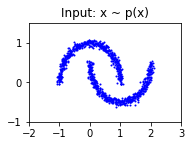

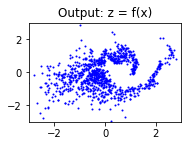

====> Test loss: -0.0567


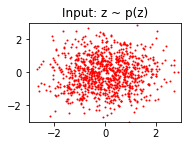

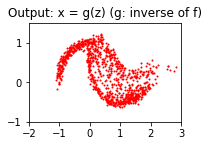

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.056225
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.055682
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.055876
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.056956
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057117
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.056798
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.057258
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.056138
====> Epoch: 2 Average train loss: -0.0563


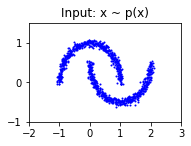

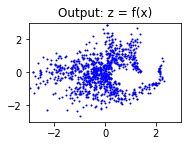

====> Test loss: -0.0583


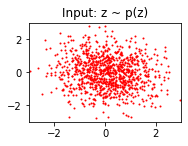

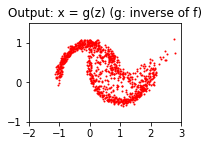

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.056012
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.058096
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.057901
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.057957
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058741
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.057664
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.057314
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.057978
====> Epoch: 3 Average train loss: -0.0578


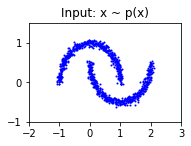

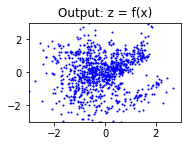

====> Test loss: -0.0594


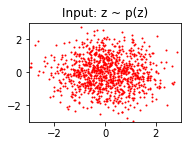

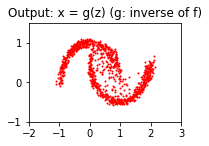

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.057338
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.058640
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.056747
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.058307
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.058658
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.059027
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.058265
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.058685
====> Epoch: 4 Average train loss: -0.0583


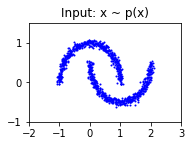

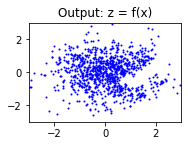

====> Test loss: -0.0604


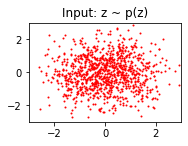

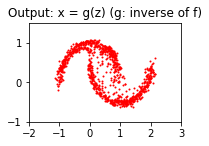

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059624
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.058240
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.058525
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.057238
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059254
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059505
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059335
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059972
====> Epoch: 5 Average train loss: -0.0587


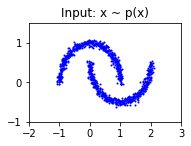

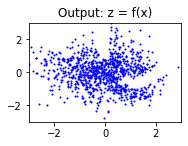

====> Test loss: -0.0601


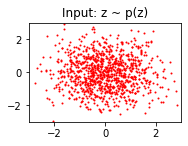

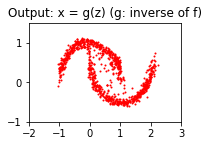

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.058629
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059699
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.059012
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059913
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.058420
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.058910
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059256
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.058669
====> Epoch: 6 Average train loss: -0.0591


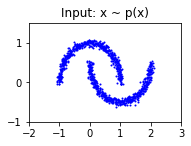

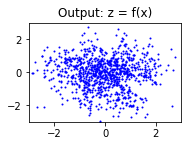

====> Test loss: -0.0607


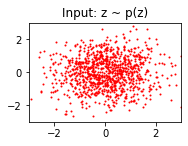

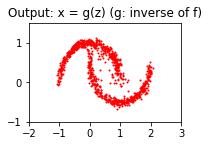

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059337
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059196
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059358
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.058729
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.057432
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059355
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.058288
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.058918
====> Epoch: 7 Average train loss: -0.0591


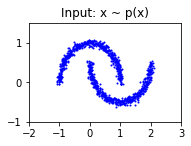

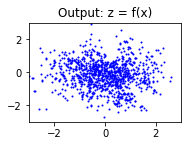

====> Test loss: -0.0606


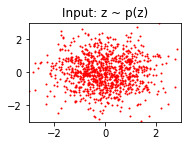

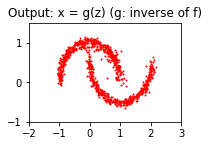

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059219
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059511
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059467
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.060057
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059373
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059924
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.059768
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.060534
====> Epoch: 8 Average train loss: -0.0595


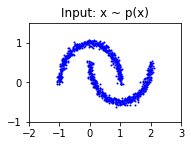

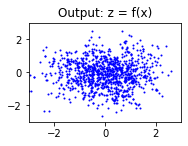

====> Test loss: -0.0608


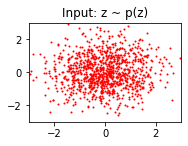

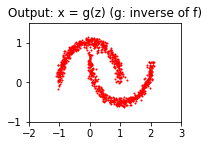

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059238
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.060232
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.058699
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.060253
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.060064
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059445
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059904
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.060183
====> Epoch: 9 Average train loss: -0.0595


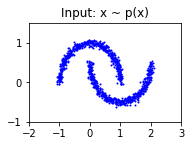

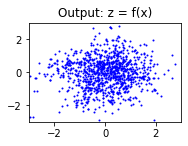

====> Test loss: -0.0610


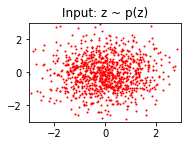

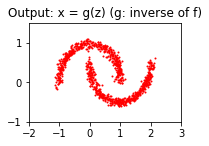

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.060061
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059358
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059471
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.060118
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.058955
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059801
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.058423
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059779
====> Epoch: 10 Average train loss: -0.0596


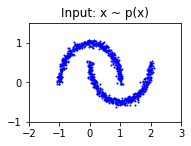

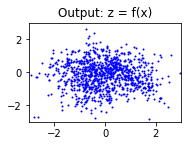

====> Test loss: -0.0608


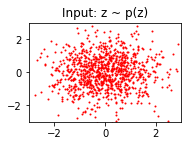

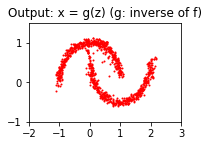

'187.68s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows does not fit well when there is many clusters in data**

> Normalizing flows is directly computing the probability relationship . When there is many clusters in data, it means the probability of the data is more cpmplex and difficult to learn. There is no optimal and ivertible function can perfectly represent the probability relationship between the generated data and real data.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> When we use GAN, 
- The advantages are: (1) It usually can generate good images, which are close to real-word stuff. (2)GAN can parallelly generate images, so it is fast. (3)There is no strict limit on the dimension of the input noise; (4) The structure is flexible
- The disadvantages are: (1)It is difficult to train, the training process is unstable. (2) Problems of gradient vanishing and mode collapse are troublesome.(3)GaN is not suitable for processing discrete data, such as text.(4)Interpretability is relatively weak

>When we use VAE,
- The advantages are: (1)It can directly compare the generated data itslef and real-world data itself with the encoder and decoder ; 
- The disadvantages are: (1)The generated images are relatively fuzzy. 

>When we use Normalizing Flows,
- The advantages are: (1) It is tractable. It can directly learn the probabilistic relationship between the real-world data and the generated data. This probability relationship is quantitative, accurate, and one-to-one. (2) It is also invertible, we can easily learn the input data by the inverse function. They gurantee the interpretability.
- The disadvantages are: (1)Since we should make the mapping function invertible and the Jacobien can be friendly computated, there are some limit on the model design. We should be careful on model designing. (2)The input dimension must be same as the output dimension